In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import subprocess
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.externals import joblib
from plotting import plot_feature_importance

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import dataset
df = pd.read_csv('./data/features-total-4a115a8.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,11910.000000,0.513889,1024.000000,34.0,34.0,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,0.003832,0.308994,4.126739,14.0,14.0,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.003622,0.434896,85.525822,67.0,0.0,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,0.000048,0.428264,342.595182,10.0,10.0,0.0,0.0,0.0,0.0,12


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


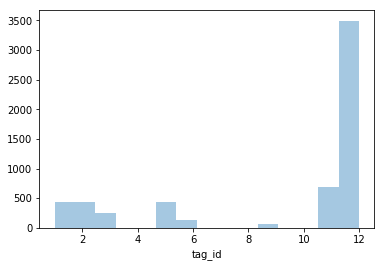

In [3]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

In [4]:
BASELINE_FEATURE_COLUMNS = [
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

In [5]:
# Evaluation utils
def plot_confusion_matrix(y_true, y_pred):
    vandalism_count = y_true.value_counts()[True]
    no_vandalism_count = y_true.value_counts()[False]
    cfn_matrix = confusion_matrix(y_true, y_pred)
    cfn_norm_matrix = np.array([[1.0/no_vandalism_count, 1.0/no_vandalism_count], [1.0/vandalism_count, 1.0/vandalism_count]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix, annot=True, fmt="d", linewidths=0.5, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix, linewidths=0.5, annot=True, ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('Classification Report')
    classes = ['No Vandalism', 'Vandalism']
    print(classification_report(y_true, y_pred, target_names=classes))
    
def plot_scores(scores):
    print('Cross validation scores')
    scores = list(scores.items())[2:]

    for score in scores:
        sns.lineplot(range(0, 10), score[1], label=score[0])
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

def plot_precision_recall(y_true, y_predict_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_predict_proba)
    average_precision = average_precision_score(y_true, y_predict_proba)
    pr_auc = auc(recall, precision)

    plt.title('Precision-Recall: Average Precision=  %0.2f' % average_precision)
    plt.step(recall, precision, color='b', where='post')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    print('Precision / Recall AUC', pr_auc)
    
def plot_roc(y_true, y_predict_proba):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predict_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('Receiver Operation Characteristic AUC', roc_auc)

In [6]:
# Preprocessing utils
class VandalismEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, tag_ids):
        self.tag_ids = tag_ids
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['is_vandalism'] = X.tag_id.isin(self.tag_ids)
        X = X.drop(['tag_id'], axis=1)
        return X

    def fit_transform(self, X, y):
        return self.transform(X)
    
class RevisionGrouper(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.groupby(X.index).apply(self._vandalism_revision_or_first)
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def _vandalism_revision_or_first(self, group):
        vandalism_revisions = group.loc[group['is_vandalism'] == True]
        return vandalism_revisions.iloc[0] if len(vandalism_revisions) > 0 else group.iloc[0]

class FeatureSelector(BaseEstimator, TransformerMixin):        
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns != None:
            # Do not remove 'is_vandalism'
            self.columns.append('is_vandalism')
            X = X[self.columns]
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

---
## Preprocessing

In [7]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

Feature config: all , Features after preprocessing: 84


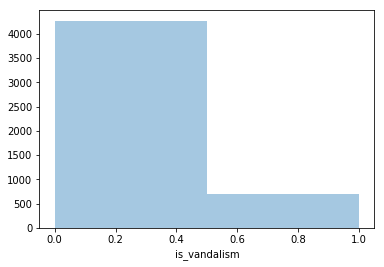

In [80]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

sns.distplot(processed_df['is_vandalism'].map(lambda x: 1 if x else 0), kde=False,  bins=2)
plt.show()

In [81]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [82]:
X

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,sizeChange,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo
revision_id,,,,,,,,,,,,,,,,,,,,,
2148821,0.0,0.0,16.0,-1.0,1.0,-1.0,1.0,0.000000,0.000000,0.000000,...,73.0,0.004293,0.492325,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2359434,0.0,0.0,0.0,-1.0,3.0,-1.0,0.0,0.666667,0.666667,0.000000,...,3292.0,3293.000000,0.711944,1024.000000,0.0,0.0,0.0,0.0,0.0,0.0
2880168,0.0,0.0,3.0,-1.0,1.0,-1.0,0.0,0.000000,0.000000,0.000000,...,6129.0,6130.000000,0.854406,734.611386,5.0,5.0,0.0,0.0,0.0,0.0
2970351,0.0,0.0,22.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.000000,...,1682.0,1683.000000,0.879781,1024.000000,0.0,0.0,0.0,0.0,0.0,0.0
2975763,1.0,0.0,0.0,18.0,2.0,1.0,0.0,-1.000000,-1.000000,-1.000000,...,-13117.0,-0.999848,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3179674,0.0,0.0,1.0,-1.0,3.0,-1.0,0.0,0.500000,0.500000,0.000000,...,745.0,746.000000,3.090909,1024.000000,0.0,0.0,0.0,0.0,0.0,0.0
3200065,0.0,0.0,0.0,-1.0,4.0,-1.0,0.0,0.333333,0.333333,0.333333,...,-8045.0,-0.702349,0.868421,0.000000,42.0,42.0,0.0,0.0,9.0,0.0
3412132,0.0,0.0,19.0,-1.0,6.0,-1.0,0.0,0.000000,0.000000,0.000000,...,17211.0,17212.000000,0.480456,1024.000000,0.0,0.0,0.0,0.0,0.0,0.0
3511384,0.0,0.0,15.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.000000,...,2265.0,2266.000000,0.695906,375.127019,82.0,82.0,0.0,0.0,0.0,0.0


In [83]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


---
## Grid search model parameters

In [84]:
# Grid search model params
# 'class_weight': ['balanced', {0:1,1:1}, {0:2,1:1}, {0:4,1:1}, {0:6,1:1}, {0:8,1:1}, {0:10,1:1}, {0:20,1:1}]
parameters = [{
    'n_estimators': [300], 
    'class_weight': ['balanced']
}]

grid_search = GridSearchCV(RandomForestClassifier(),
                           parameters, 
                           scoring=['f1', 'precision', 'recall', 'roc_auc'],
                           refit='f1',
                           cv=10,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

Best params {'class_weight': 'balanced', 'n_estimators': 300}
Best score 0.4342557039725447


---
## Train: Cross evaluate model using best parameters

In [85]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

Cross validation scores


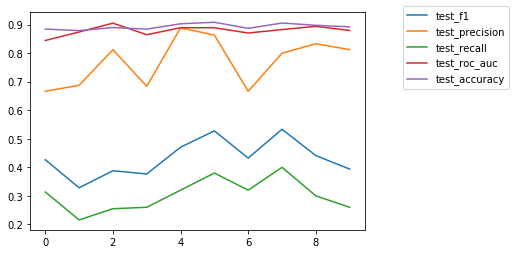

In [86]:
plot_scores(train_scores)

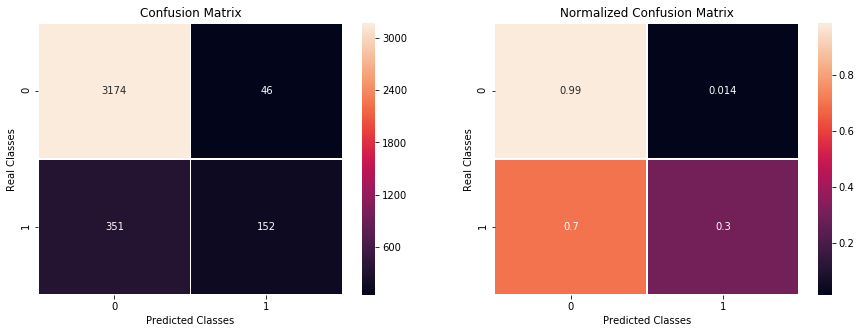

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.90      0.99      0.94      3220
   Vandalism       0.77      0.30      0.43       503

 avg / total       0.88      0.89      0.87      3723



In [87]:
plot_confusion_matrix(y_train, y_train_predict)

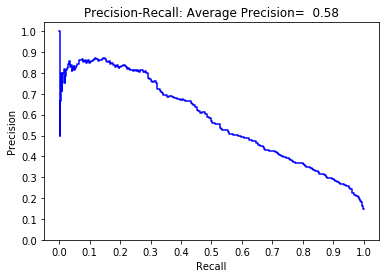

Precision / Recall AUC 0.5783978892314813


In [88]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

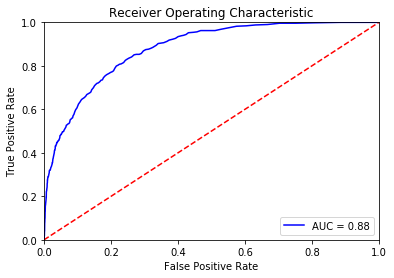

Receiver Operation Characteristic AUC 0.8786384179395677


In [89]:
plot_roc(y_train, y_train_predict_proba[:, 1])

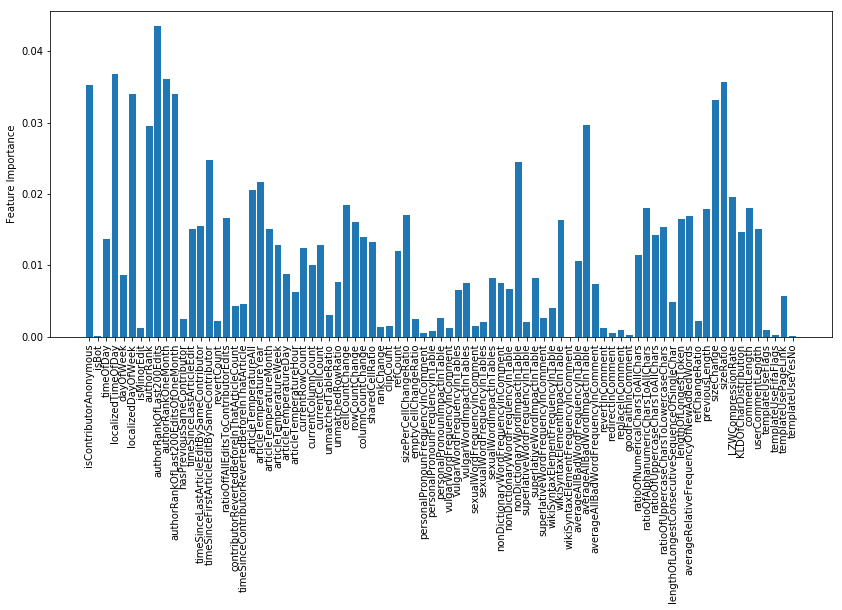

In [90]:
# Feature importance
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)
plot_feature_importance(clf, X_train.columns)

---
## Test: Test model on final test dataset

In [91]:
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [92]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

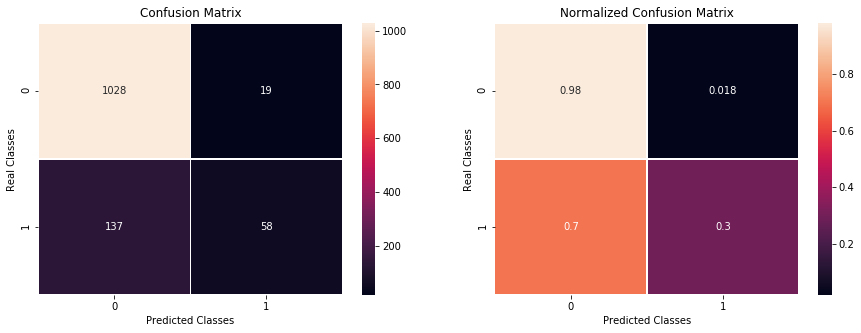

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.88      0.98      0.93      1047
   Vandalism       0.75      0.30      0.43       195

 avg / total       0.86      0.87      0.85      1242



In [93]:
plot_confusion_matrix(y_test, y_test_predict)

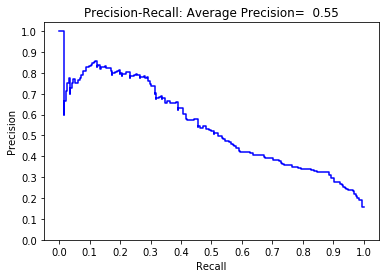

Precision / Recall AUC 0.5462005096793978


In [94]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

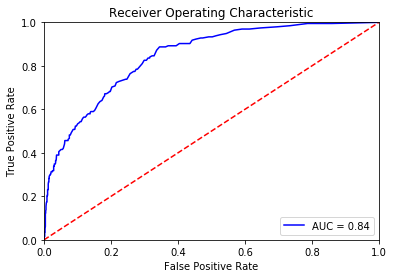

Receiver Operation Characteristic AUC 0.8443562804594322


In [95]:
plot_roc(y_test, y_test_predict_proba[:, 1])

In [96]:
# False positives for the test set
fp_test = X_test[(y_test == 0) & (y_test_predict == 1)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']]

,tag_id
revision_id,
63501416,1
65786291,12
96080973,12
138102629,1
162699934,2
168554610,5
171657605,12
216428585,6
250151424,12


In [97]:
# False negatives for the test set
fp_test = X_test[(y_test == 1) & (y_test_predict == 0)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']]

,tag_id
revision_id,
15540587,5
15540587,11
21782017,2
21782017,11
29789136,11
29789136,5
45492728,1
45492728,2
45492728,11
